In [1]:
import pandas as pd
import pyfolio as pf
import matplotlib.pyplot as plt
from genesis import *

c:\users\vin_s\appdata\local\programs\python\python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# Price Data 

In [61]:
px = read_prices("../Dymon/Code Data/carry_adj_fx_returns.csv")
px.columns = [x[0] for x in px.columns]
rtns = px.pct_change()

rtns_copy = copy(rtns)

rtns = pd.DataFrame()
for i in list(rtns_copy):
  if i[:3] != "USD":
    col = rtns_copy.loc[:,i] * -1
    col.name = i[3:] + i[:3]
  else:
    col = rtns_copy.loc[:,i]
    col.name = i
  rtns = pd.concat([rtns, col], axis = 1)
  
  
# rtns = px.pct_change()
rtns.index = pd.to_datetime(rtns.index)
rtns = rtns.loc[:"2016-12-31"]

In [62]:
rtns = rtns[["USDAUD", "USDCAD", "USDEUR", "USDGBP", "USDJPY", "USDNZD", "USDSEK", "USDNOK", "USDCHF"]]
# rtns = rtns[[x for x in list(rtns) if x not in ["USDAUD", "USDCAD", "USDEUR", "USDGBP", "USDJPY", "USDNZD", "USDSEK", "USDNOK", "USDCHF"]]]

# Settings

In [63]:
s = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=130,
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=130,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=260)

# Other Data

In [64]:
vix = pd.read_csv("../Dymon/Code Data/vix.csv", index_col=0).iloc[2:]

In [65]:
vix = vix["VIX Index"].astype(float)

# Signal 

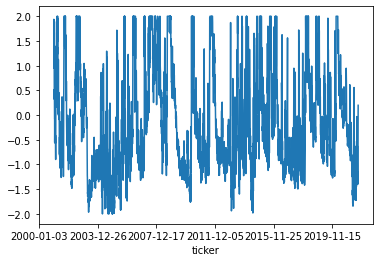

In [66]:
signal = cap_helper(zscore(vix.ffill(), 252),2)
signal.plot()
sig = pd.concat([signal] * len(rtns.columns), axis=1)
sig.columns = rtns.columns
sig.index = pd.to_datetime(sig.index)
sig = sig.loc[:"2016"]

In [67]:
b = Backtest(signal = sig, asset_returns = rtns, tcost = abs(rtns*0), settings = s)
b.run()

Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [68]:
full_summary(b, "2003")

Returns   : 0.031198478441747873
Vol       : 0.10977638691091227
SR        : 0.28420026673920895
Hit rate  : 0.516
W | N | L : 0.48 | 0.04 | 0.48
W/L Ratio : 0.99
----------------------------------
Returns   : 0.029575338837683526
Vol       : 0.10910688429582299
SR        : 0.27106757771118734
Hit rate  : 0.535
W | N | L : 0.46 | 0.07 | 0.47
W/L Ratio : 1.0


In [69]:
get_returns_stats(b.asset_rtn.loc["2003":], b.wts.loc["2003":])

,USDAUD,USDCAD,USDEUR,USDGBP,USDJPY,USDNZD,USDSEK,USDNOK,USDCHF
annualized_return,0.441139,0.438686,0.410892,0.817531,-0.565916,0.64403,0.536192,0.327417,0.069878
sharpe,0.24975,0.258976,0.251636,0.498482,-0.32796,0.376788,0.33188,0.204208,0.028873
dollar_sharpe,0.232277,0.247142,0.243491,0.486,-0.331065,0.361869,0.321425,0.193337,0.015956
trade_sharpe,0.24975,0.258976,0.251636,0.498482,-0.32796,0.376788,0.33188,0.204208,0.028873
long_sharpe,0.162164,0.221948,0.391893,0.973276,-0.000717,0.111946,0.594675,0.189132,-0.088119
short_sharpe,0.379187,0.377521,0.133918,0.162034,-0.64709,0.615508,0.134869,0.210003,0.152891
sortino,0.161358,0.16084,0.157925,0.337114,-0.184774,0.248433,0.214962,0.130318,0.01227
max_drawdown,-4.781714,-4.635959,-6.251739,-3.77186,-12.617561,-4.291109,-4.276628,-4.326157,-7.304846
max_drawdown_start,2011-10-03,2006-05-23,2007-08-16,2012-12-20,2007-06-22,2007-08-16,2007-08-16,2007-08-16,2014-05-06
max_drawdown_end,2016-12-23,2007-11-06,2011-07-12,2013-03-12,2014-10-15,2008-09-19,2008-09-22,2008-09-22,2015-01-15


<AxesSubplot:ylabel='Cumulative returns'>

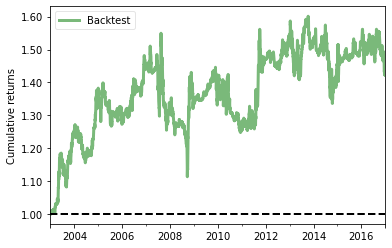

In [70]:
pf.plot_rolling_returns(b.model_rtn.loc["2003":])

In [71]:
bt_obj = b

<AxesSubplot:title={'center':'Distribution of monthly returns'}, xlabel='Returns', ylabel='Number of months'>

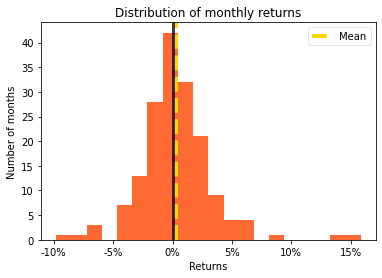

In [72]:
pf.plot_monthly_returns_dist(bt_obj.model_rtn.loc["2003":])

<AxesSubplot:title={'center':'Monthly returns (%)'}, xlabel='Month', ylabel='Year'>

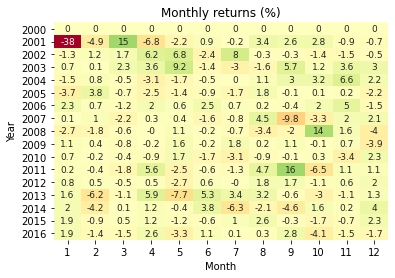

In [73]:
pf.plot_monthly_returns_heatmap(bt_obj.model_rtn)

In [74]:
shorts = bt_obj.asset_rtn_tc[bt_obj.wts < 0].fillna(0).sum(1)
longs = bt_obj.asset_rtn_tc[bt_obj.wts > 0].fillna(0).sum(1)

<AxesSubplot:ylabel='Cumulative returns'>

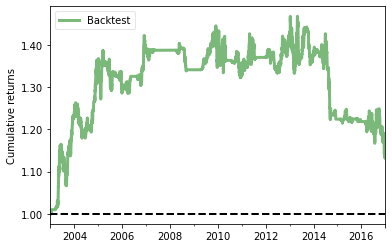

In [75]:
pf.plotting.plot_rolling_returns(shorts.loc["2003":])

<AxesSubplot:ylabel='Cumulative returns'>

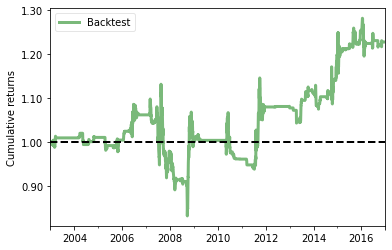

In [76]:
pf.plotting.plot_rolling_returns(longs.loc["2003":])

In [77]:
longs.name = "Long"

In [78]:
shorts.name = "Shorts"

<AxesSubplot:ylabel='Cumulative returns'>

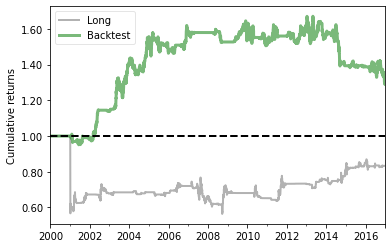

In [79]:
pf.plotting.plot_rolling_returns(shorts, longs)

USDAUD


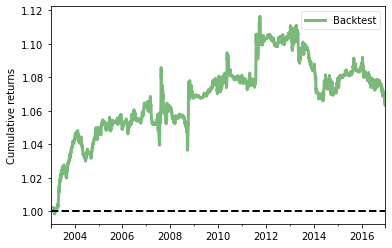

USDCAD


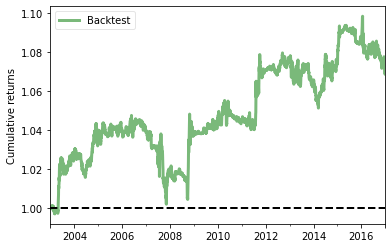

USDEUR


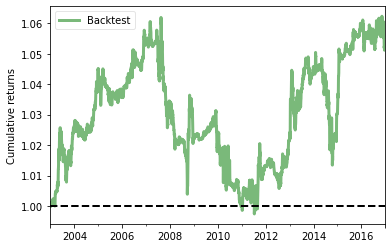

USDGBP


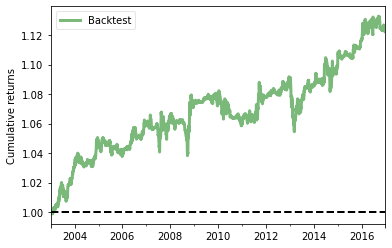

USDJPY


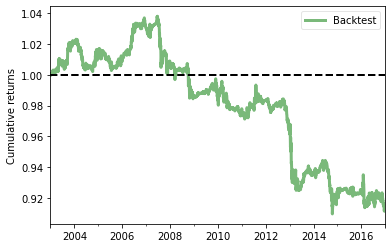

USDNZD


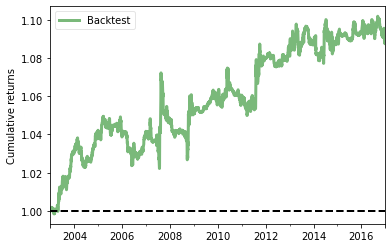

USDSEK


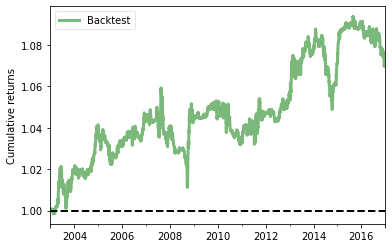

USDNOK


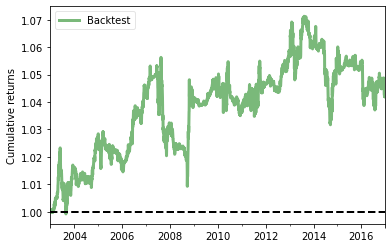

USDCHF


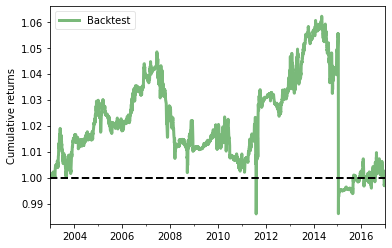

In [80]:
for i in rtns.columns:
  print(i)
  bt_returns = bt_obj.asset_rtn_tc[i]
  pf.plotting.plot_rolling_returns(bt_returns.loc["2003":])
  plt.show()

In [ ]:
fig = pf.create_returns_tear_sheet(b3.model_rtn_tc[b3.model_rtn.index > "2000-01-01"], return_fig=True)

for ax in fig.axes:
        ax.tick_params(
        axis='x',           # changes apply to the x-axis
        which='both',       # both major and minor ticks are affected
        bottom=True,
        top=False,
        labelbottom=True)    # labels along the bottom edge are on